In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 50)

In [60]:
from statsmodels.nonparametric.smoothers_lowess import lowess


# Win expectancy

## IPL games

### Import pre-processed all IPL data

In [3]:
df = pd.read_csv("data/df_kaggleAllIpl_preprocessed.csv")
del df['Unnamed: 0']

In [4]:
df

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN
5,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,6,S Dhawan,DA Warner,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
6,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,7,S Dhawan,DA Warner,TS Mills,0,0,0,1,0,0,0,1,1,NaN,NaN,NaN
7,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,1,S Dhawan,DA Warner,A Choudhary,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN
8,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,2,DA Warner,S Dhawan,A Choudhary,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
9,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,3,DA Warner,S Dhawan,A Choudhary,0,0,0,0,1,0,0,1,1,NaN,NaN,NaN


In [5]:
len(df)

150460

In [29]:
df["dismissal_kind"].unique()

array([nan, 'caught', 'bowled', 'run out', 'lbw', 'caught and bowled',
       'stumped', 'retired hurt', 'hit wicket', 'obstructing the field'], dtype=object)

### Ball by ball win expectancy

### All IPL games

In [6]:
maxRunRateBins = 300
maxBalls = 240

numOccurrences  = np.ndarray(shape=(maxBalls,maxRunRateBins,11), dtype='float')
numTeamChaseWin = np.ndarray(shape=(maxBalls,maxRunRateBins,11), dtype='float')

for m in df['match_id'].unique():
    
    if m%100==0:
        print(m)
        
    dfm = df[df['match_id']==m]
    
    if dfm['result'].unique()[0]=="normal" and dfm['dl_applied'].unique()[0]==0: ### Ignore ties and matches with DL method
        
        ### Count number of instances when team chasing wins the game
        teamChase = dfm[dfm['inning']==2]['batting_team'].unique()[0]
        winner = dfm['winner'].unique()[0]
        teamChaseWin = 1 if (teamChase==winner) else 0

        ball = 0
        firstInningsRuns = 0
        secondInningsRuns = 0
        firstInningsWickets = 0
        secondInningsWickets = 0
        
        for b in range(len(dfm)):  ### For each ball in the match
            
            innings = dfm.iloc[b]['inning']
            
            if dfm.iloc[b]['wide_runs']==0 and dfm.iloc[b]['noball_runs']==0:  ### Do not count wides/no-balls
                ball += 1
              
            if innings==2 and ball==121:    ### Start of second innings
                target = firstInningsRuns+1
                numBallsRemaining = maxBalls/2
                
            if ball!=0 and innings==1:    ### First innings
                firstInningsRuns += dfm.iloc[b]['total_runs']
                runRate = int(np.around(firstInningsRuns/ball)*10)
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    firstInningsWickets += 1
                    
                numOccurrences[ball, runRate, firstInningsWickets] += 1
                numTeamChaseWin[ball, runRate, firstInningsWickets] += teamChaseWin
                
            elif innings==2 and numBallsRemaining>1:  ### Second innings   
                numBallsRemaining = maxBalls-ball
                numRunsRemaining = target-secondInningsRuns
                secondInningsRuns += dfm.iloc[b]['total_runs']
                requiredRunRate = int(np.around(numRunsRemaining/numBallsRemaining)*10)
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    secondInningsWickets += 1
            
                if requiredRunRate >= maxRunRateBins:
                    requiredRunRate = maxRunRateBins-1
                numOccurrences[ball, requiredRunRate, secondInningsWickets] += 1
                numTeamChaseWin[ball, requiredRunRate, secondInningsWickets] += teamChaseWin
            

100
200
300
400
500
600


In [9]:
we = numTeamChaseWin/numOccurrences

In [16]:
pd.isnull(dfm.iloc[10]["player_dismissed"])

True

In [17]:
dfm.iloc[11]["bowler"]

'A Choudhary'

In [20]:
tmp = {}

In [23]:
if "a" in tmp:
    tmp["a"] += 1
else:
    tmp["a"] = 1

In [24]:
tmp

{'a': 1}

In [67]:
maxRunRateBins = 300
maxBalls = 240

we1 = [0] * 240
we1[0] = 0.5
wpa = {}

for m in [2]: #df['match_id'].unique():
    
    if m%100==0:
        print(m)
        
    dfm = df[df['match_id']==m]
    
    if dfm['result'].unique()[0]=="normal" and dfm['dl_applied'].unique()[0]==0: ### Ignore ties and matches with DL method
        
        ### Count number of instances when team chasing wins the game
        teamChase = dfm[dfm['inning']==2]['batting_team'].unique()[0]
        winner = dfm['winner'].unique()[0]
        teamChaseWin = 1 if (teamChase==winner) else 0

        ball = 0
        firstInningsRuns = 0
        secondInningsRuns = 0
        firstInningsWickets = 0
        secondInningsWickets = 0
        
        for b in range(len(dfm)):  ### For each ball in the match
            
            innings = dfm.iloc[b]['inning']
            
            if dfm.iloc[b]['wide_runs']==0 and dfm.iloc[b]['noball_runs']==0:  ### Do not count wides/no-balls
                ball += 1
              
            if innings==2 and ball==121:    ### Start of second innings
                target = firstInningsRuns+1
                numBallsRemaining = maxBalls/2
                
            if ball!=0 and innings==1:    ### First innings
                firstInningsRuns += dfm.iloc[b]['total_runs']
                runRate = int(np.around(firstInningsRuns/ball)*10)
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    firstInningsWickets += 1
                    
                we1[ball] = we[ball, runRate, firstInningsWickets]
                #deltaWe = we1[ball] - we1[ball-1]
                filtered = lowess(we1, range(len(we1)), is_sorted=True, frac=0.1)
                deltaWe = filtered[ball,1] - filtered[ball-1,1]
                
                if deltaWe>0:
                    batsman = dfm.iloc[b]["batsman"]
                    if batsman in wpa:
                        wpa[batsman] += deltaWe/2
                    else:
                        wpa[batsman] = deltaWe/2
                    
                    bowler = dfm.iloc[b]["bowler"]
                    if bowler in wpa:
                        wpa[bowler] -= deltaWe/2
                    else:
                        wpa[bowler] = -deltaWe/2
                    
                else:
                    
                    if (not pd.isnull(dfm.iloc[b]["player_dismissed"])) and (dfm.iloc[b]["dismissal_kind"]=="run out"):   
                        fielder = dfm.iloc[b]["fielder"]
                        if fielder in wpa:
                            wpa[fielder] += deltaWe/2
                        else:
                            wpa[fielder] = deltaWe/2
                        
                        dismissedBatsman = dfm.iloc[b]["player_dismissed"]
                        if dismissedBatsman in wpa:
                            wpa[dismissedBatsman] -= deltaWe/2
                        else:
                            wpa[dismissedBatsman] = -deltaWe/2
                    else:  
                        bowler = dfm.iloc[b]["bowler"]
                        if bowler in wpa:
                            wpa[bowler] += deltaWe/2
                        else:
                            wpa[bowler] = deltaWe/2
                        
                        batsman = dfm.iloc[b]["batsman"]
                        if batsman in wpa:
                            wpa[batsman] -= deltaWe/2
                        else:
                            wpa[batsman] = -deltaWe/2

                        

                            
            elif innings==2 and numBallsRemaining>1:  ### Second innings   
                numBallsRemaining = maxBalls-ball
                numRunsRemaining = target-secondInningsRuns
                secondInningsRuns += dfm.iloc[b]['total_runs']
                requiredRunRate = int(np.around(numRunsRemaining/numBallsRemaining)*10)
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    secondInningsWickets += 1
            
                if requiredRunRate >= maxRunRateBins:
                    requiredRunRate = maxRunRateBins-1
                    
                we1[ball] = we[ball, requiredRunRate, secondInningsWickets]
                #deltaWe = we1[ball] - we1[ball-1]

                filtered = lowess(we1, range(len(we1)), is_sorted=True, frac=0.1)
                deltaWe = filtered[ball,1] - filtered[ball-1,1]
                
                if deltaWe<0:
                    batsman = dfm.iloc[b]["batsman"]
                    if batsman in wpa:
                        wpa[batsman] += deltaWe/2
                    else:
                        wpa[batsman] = deltaWe/2
                    
                    bowler = dfm.iloc[b]["bowler"]
                    if bowler in wpa:
                        wpa[bowler] -= deltaWe/2
                    else:
                        wpa[bowler] = -deltaWe/2
                    
                else:
                    
                    if (not pd.isnull(dfm.iloc[b]["player_dismissed"])) and (dfm.iloc[b]["dismissal_kind"]=="run out"):   
                        fielder = dfm.iloc[b]["fielder"]
                        if fielder in wpa:
                            wpa[fielder] += deltaWe/2
                        else:
                            wpa[fielder] = deltaWe/2
                        
                        dismissedBatsman = dfm.iloc[b]["player_dismissed"]
                        if dismissedBatsman in wpa:
                            wpa[dismissedBatsman] -= deltaWe/2
                        else:
                            wpa[dismissedBatsman] = -deltaWe/2
                    else:  
                        bowler = dfm.iloc[b]["bowler"]
                        if bowler in wpa:
                            wpa[bowler] += deltaWe/2
                        else:
                            wpa[bowler] = deltaWe/2
                        
                        batsman = dfm.iloc[b]["batsman"]
                        if batsman in wpa:
                            wpa[batsman] -= deltaWe/2
                        else:
                            wpa[batsman] = -deltaWe/2


In [66]:
wpa

{'A Zampa': 0.20989629634247653,
 'AB Dinda': 0.71257329797453484,
 'AM Rahane': 0.40605637281786994,
 'AT Rayudu': -0.12762175891498639,
 'BA Stokes': 1.1633794652400367,
 'DL Chahar': 0.1760343842445844,
 'HH Pandya': -1.2769293237034365,
 'Imran Tahir': 0.69425869302093046,
 'JC Buttler': -0.52673441948533162,
 'JJ Bumrah': -0.39878494717256568,
 'KA Pollard': -0.33909645365668756,
 'KH Pandya': -0.24477603999551578,
 'MA Agarwal': 0.11847290298694794,
 'MJ McClenaghan': -0.33511555391200931,
 'MS Dhoni': 0.21579456575440312,
 'N Rana': -0.25170905798542542,
 'PA Patel': -0.16198760410204155,
 'R Bhatia': 0.22553366938618874,
 'RG Sharma': -0.21140763031006934,
 'SPD Smith': 0.76188496031621977,
 'TG Southee': -0.8097218188461226}

In [54]:
filtered = lowess(we1, range(len(we1)), is_sorted=True, frac=0.1)

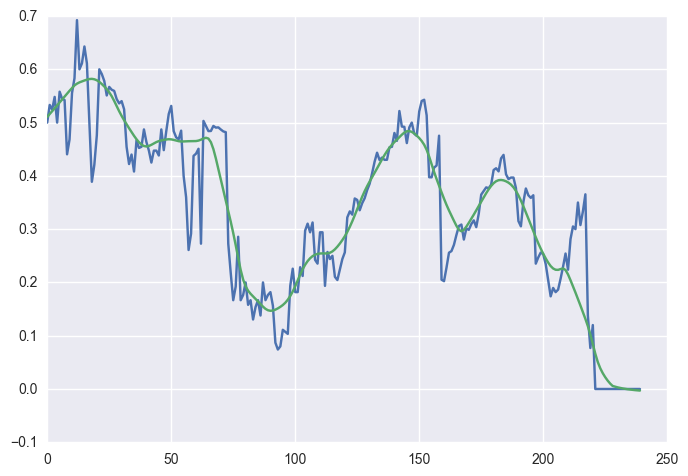

In [55]:
plt.plot(we1)
plt.plot(range(len(filtered)), filtered[:,1])